In [1]:
from pyspark import SparkConf, SparkContext

In [2]:
import collections

In [3]:
conf = SparkConf().setMaster("local").setAppName("Practice")

In [4]:
sc = SparkContext(conf= conf)

In [5]:
#Reading the data

fraud = sc.textFile('ccFraud.csv')

In [7]:
#Checking the columns
header = fraud.first()

In [8]:
header

'"custID","gender","state","cardholder","balance","numTrans","numIntlTrans","creditLine","fraudRisk"'

In [9]:
fraud = fraud \
.filter(lambda row: row != header) \
.map(lambda row: [int(elem) for elem in row.split(',')])

In [10]:
#Next, we create the schema for our DataFrame:

In [12]:
import pyspark.sql.types as typ

In [13]:
fields = [
    *[
        typ.StructField(h[1:-1], typ.IntegerType(), True)
        for h in header.split(',')
    ]
] 
schema = typ.StructType(fields)

In [14]:
fields

[StructField(custID,IntegerType,true),
 StructField(gender,IntegerType,true),
 StructField(state,IntegerType,true),
 StructField(cardholder,IntegerType,true),
 StructField(balance,IntegerType,true),
 StructField(numTrans,IntegerType,true),
 StructField(numIntlTrans,IntegerType,true),
 StructField(creditLine,IntegerType,true),
 StructField(fraudRisk,IntegerType,true)]

In [21]:
import pyspark.sql.functions as fn
from pyspark.sql import SparkSession

spark = SparkSession \
        .builder \
        .appName("Python Spark SQL basic example") \
        .config("spark.some.config.option", "some-value") \
        .getOrCreate()
        
        
sqlContext = SQLContext(spark)

NameError: name 'SQLContext' is not defined

In [20]:
fraud_df = spark.createDataFrame(fraud, schema)

In [22]:
fraud_df.show(5)

+------+------+-----+----------+-------+--------+------------+----------+---------+
|custID|gender|state|cardholder|balance|numTrans|numIntlTrans|creditLine|fraudRisk|
+------+------+-----+----------+-------+--------+------------+----------+---------+
|     1|     1|   35|         1|   3000|       4|          14|         2|        0|
|     2|     2|    2|         1|      0|       9|           0|        18|        0|
|     3|     2|    2|         1|      0|      27|           9|        16|        0|
|     4|     1|   15|         1|      0|      12|           0|         5|        0|
|     5|     1|   46|         1|      0|      11|          16|         7|        0|
+------+------+-----+----------+-------+--------+------------+----------+---------+
only showing top 5 rows



In [23]:
fraud_df.columns

['custID',
 'gender',
 'state',
 'cardholder',
 'balance',
 'numTrans',
 'numIntlTrans',
 'creditLine',
 'fraudRisk']

In [30]:
#To find the PErcentage of missing observations per column, we can use the following snippet:

fraud_df.agg(*[
(1 - (fn.count(c) / fn.count('*'))).alias(c + '_missing')
for c in fraud_df.columns
]).show()
#It produces the following output:

+--------------+--------------+-------------+------------------+---------------+----------------+--------------------+------------------+-----------------+
|custID_missing|gender_missing|state_missing|cardholder_missing|balance_missing|numTrans_missing|numIntlTrans_missing|creditLine_missing|fraudRisk_missing|
+--------------+--------------+-------------+------------------+---------------+----------------+--------------------+------------------+-----------------+
|           0.0|           0.0|          0.0|               0.0|            0.0|             0.0|                 0.0|               0.0|              0.0|
+--------------+--------------+-------------+------------------+---------------+----------------+--------------------+------------------+-----------------+



In [24]:
fraud_df.groupBy('gender').count().show()

+------+-------+
|gender|  count|
+------+-------+
|     1|6178231|
|     2|3821769|
+------+-------+



In [26]:
fraud_df.groupBy('gender').mean('balance').show()

+------+-----------------+
|gender|     avg(balance)|
+------+-----------------+
|     1|4111.134073976839|
|     2|4107.957129800362|
+------+-----------------+



In [27]:
numerical = ['balance', 'numTrans', 'numIntlTrans']
desc = fraud_df.describe(numerical)
desc.show()

+-------+-----------------+------------------+-----------------+
|summary|          balance|          numTrans|     numIntlTrans|
+-------+-----------------+------------------+-----------------+
|  count|         10000000|          10000000|         10000000|
|   mean|     4109.9199193|        28.9351871|        4.0471899|
| stddev|3996.847309737258|26.553781024523122|8.602970115863904|
|    min|                0|                 0|                0|
|    max|            41485|               100|               60|
+-------+-----------------+------------------+-----------------+



In [28]:
fraud_df.agg({'balance': 'skewness'}).show()

+------------------+
| skewness(balance)|
+------------------+
|1.1818315552993839|
+------------------+



# Correlations

In [29]:
fraud_df.corr('balance', 'numTrans')


0.0004452314017265386

In [31]:
# Correlatiom Matrix
n_numerical = len(numerical)
corr = []
for i in range(0, n_numerical):
    temp = [None] * i
    for j in range(i, n_numerical):
        temp.append(fraud_df.corr(numerical[i], numerical[j]))
    corr.append(temp)

In [33]:
corr

[[1.0, 0.0004452314017265386, 0.0002713991339817875],
 [None, 1.0, -0.00028057128198165544],
 [None, None, 1.0]]

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [40]:
from pyspark.mllib.stat import Statistics

In [42]:
def compute_correlation_matrix(df, method='pearson'):
    # wrapper around
    # https://forums.databricks.com/questions/3092/how-to-calculate-correlation-matrix-with-all-colum.html
    df_rdd = df.rdd.map(lambda row: row[0:])
    corr_mat = Statistics.corr(df_rdd, method=method)
    corr_mat_df = pd.DataFrame(corr_mat,
                    columns=df.columns, 
                    index=df.columns)
    return corr_mat_df

In [43]:
compute_correlation_matrix(fraud_df, method='pearson')

,custID,gender,state,cardholder,balance,numTrans,numIntlTrans,creditLine,fraudRisk
custID,1.000000,-0.000523,-0.000123,-0.000006,0.000264,0.000610,0.000054,0.000084,-0.000427
gender,-0.000523,1.000000,0.000279,0.000204,-0.000386,-0.000187,0.000007,0.000042,0.037425
state,-0.000123,0.000279,1.000000,-0.000459,-0.000896,0.000151,-0.000301,-0.000263,-0.022295
cardholder,-0.000006,0.000204,-0.000459,1.000000,-0.000458,0.000243,0.000272,-0.000132,0.011154
balance,0.000264,-0.000386,-0.000896,-0.000458,1.000000,0.000445,0.000271,0.263583,0.412075
numTrans,0.000610,-0.000187,0.000151,0.000243,0.000445,1.000000,-0.000281,0.000317,0.222751
numIntlTrans,0.000054,0.000007,-0.000301,0.000272,0.000271,-0.000281,1.000000,-0.000279,0.039588
creditLine,0.000084,0.000042,-0.000263,-0.000132,0.263583,0.000317,-0.000279,1.000000,0.377001
fraudRisk,-0.000427,0.037425,-0.022295,0.011154,0.412075,0.222751,0.039588,0.377001,1.000000


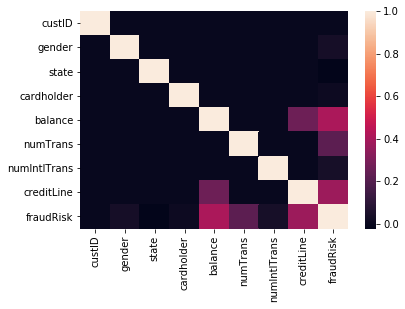

In [44]:
sns.heatmap(compute_correlation_matrix(fraud_df, method='pearson'))

# HISTOGRAM

In [50]:
# In order to create a histogram, it is important to aggregate the data first and then plot

In [45]:
hists = fraud_df.select('balance').rdd.flatMap(lambda row: row).histogram(20)

Text(0.5,1,"Histogram of 'balance'")

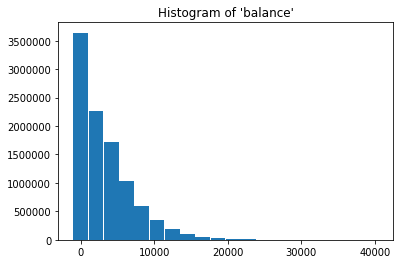

In [53]:
import matplotlib.pyplot as plt
%matplotlib inline


data = {
'bins': hists[0][:-1],
'freq': hists[1]
} 

plt.bar(data['bins'], data['freq'], width=2000)
plt.title('Histogram of \'balance\'')

In [54]:
#USING BOKEH

AttributeError: module 'bokeh' has no attribute 'Histogram'

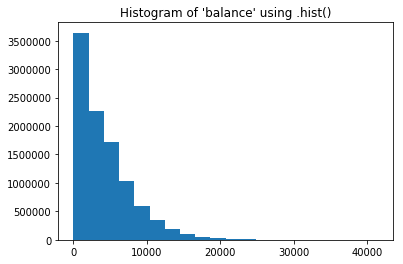

In [64]:
data_driver = {
'obs': fraud_df.select('balance').rdd.flatMap(
lambda row: row
).collect()
}

plt.hist(data_driver['obs'], bins=20)
plt.title('Histogram of \'balance\' using .hist()')
b_hist_driver = chrt.Histogram(
data_driver, values='obs',
title='Histogram of \'balance\' using .Histogram()',
bins=20
) 

# SCATTER PLOT

In [65]:
data_sample = fraud_df.sampleBy(
'gender', {1: 0.0002, 2: 0.0002}
).select(numerical)

In [66]:
data_multi = dict([
(elem, data_sample.select(elem).rdd \
.flatMap(lambda row: row).collect())
for elem in numerical
])
sctr = chrt.Scatter(data_multi, x='balance', y='numTrans')
chrt.show(sctr)

AttributeError: module 'bokeh' has no attribute 'Scatter'

# MLLIB

In [69]:
import pyspark.sql.types as typ

labels = [
    ('INFANT_ALIVE_AT_REPORT', typ.StringType()),
    ('BIRTH_YEAR', typ.IntegerType()),
    ('BIRTH_MONTH', typ.IntegerType()),
    ('BIRTH_PLACE', typ.StringType()),
    ('MOTHER_AGE_YEARS', typ.IntegerType()),
    ('MOTHER_RACE_6CODE', typ.StringType()),
    ('MOTHER_EDUCATION', typ.StringType()),
    ('FATHER_COMBINED_AGE', typ.IntegerType()),
    ('FATHER_EDUCATION', typ.StringType()),
    ('MONTH_PRECARE_RECODE', typ.StringType()),
    ('CIG_BEFORE', typ.IntegerType()),
    ('CIG_1_TRI', typ.IntegerType()),
    ('CIG_2_TRI', typ.IntegerType()),
    ('CIG_3_TRI', typ.IntegerType()),
    ('MOTHER_HEIGHT_IN', typ.IntegerType()),
    ('MOTHER_BMI_RECODE', typ.IntegerType()),
    ('MOTHER_PRE_WEIGHT', typ.IntegerType()),
    ('MOTHER_DELIVERY_WEIGHT', typ.IntegerType()),
    ('MOTHER_WEIGHT_GAIN', typ.IntegerType()),
    ('DIABETES_PRE', typ.StringType()),
    ('DIABETES_GEST', typ.StringType()),
    ('HYP_TENS_PRE', typ.StringType()),
    ('HYP_TENS_GEST', typ.StringType()),
    ('PREV_BIRTH_PRETERM', typ.StringType()),
    ('NO_RISK', typ.StringType()),
    ('NO_INFECTIONS_REPORTED', typ.StringType()),
    ('LABOR_IND', typ.StringType()),
    ('LABOR_AUGM', typ.StringType()),
    ('STEROIDS', typ.StringType()),
    ('ANTIBIOTICS', typ.StringType()),
    ('ANESTHESIA', typ.StringType()),
    ('DELIV_METHOD_RECODE_COMB', typ.StringType()),
    ('ATTENDANT_BIRTH', typ.StringType()),
    ('APGAR_5', typ.IntegerType()),
    ('APGAR_5_RECODE', typ.StringType()),
    ('APGAR_10', typ.IntegerType()),
    ('APGAR_10_RECODE', typ.StringType()),
    ('INFANT_SEX', typ.StringType()),
    ('OBSTETRIC_GESTATION_WEEKS', typ.IntegerType()),
    ('INFANT_WEIGHT_GRAMS', typ.IntegerType()),
    ('INFANT_ASSIST_VENTI', typ.StringType()),
    ('INFANT_ASSIST_VENTI_6HRS', typ.StringType()),
    ('INFANT_NICU_ADMISSION', typ.StringType()),
    ('INFANT_SURFACANT', typ.StringType()),
    ('INFANT_ANTIBIOTICS', typ.StringType()),
    ('INFANT_SEIZURES', typ.StringType()),
    ('INFANT_NO_ABNORMALITIES', typ.StringType()),
    ('INFANT_ANCEPHALY', typ.StringType()),
    ('INFANT_MENINGOMYELOCELE', typ.StringType()),
    ('INFANT_LIMB_REDUCTION', typ.StringType()),
    ('INFANT_DOWN_SYNDROME', typ.StringType()),
    ('INFANT_SUSPECTED_CHROMOSOMAL_DISORDER', typ.StringType()),
    ('INFANT_NO_CONGENITAL_ANOMALIES_CHECKED', typ.StringType()),
    ('INFANT_BREASTFED', typ.StringType())
]

schema = typ.StructType([
        typ.StructField(e[0], e[1], False) for e in labels
    ])

In [70]:
births = spark.read.csv('births_train.csv', 
                        header=True, 
                        schema=schema)

In [71]:
recode_dictionary = {
    'YNU': {
        'Y': 1,
        'N': 0,
        'U': 0
    }
}

In [72]:
recode_dictionary

{'YNU': {'N': 0, 'U': 0, 'Y': 1}}

In [76]:
type(births)

pyspark.sql.dataframe.DataFrame

In [77]:
selected_features = [
    'INFANT_ALIVE_AT_REPORT', 
    'BIRTH_PLACE', 
    'MOTHER_AGE_YEARS', 
    'FATHER_COMBINED_AGE', 
    'CIG_BEFORE', 
    'CIG_1_TRI', 
    'CIG_2_TRI', 
    'CIG_3_TRI', 
    'MOTHER_HEIGHT_IN', 
    'MOTHER_PRE_WEIGHT', 
    'MOTHER_DELIVERY_WEIGHT', 
    'MOTHER_WEIGHT_GAIN', 
    'DIABETES_PRE', 
    'DIABETES_GEST', 
    'HYP_TENS_PRE', 
    'HYP_TENS_GEST', 
    'PREV_BIRTH_PRETERM'
]

births_trimmed = births.select(selected_features)

In [78]:
births_trimmed.columns

['INFANT_ALIVE_AT_REPORT',
 'BIRTH_PLACE',
 'MOTHER_AGE_YEARS',
 'FATHER_COMBINED_AGE',
 'CIG_BEFORE',
 'CIG_1_TRI',
 'CIG_2_TRI',
 'CIG_3_TRI',
 'MOTHER_HEIGHT_IN',
 'MOTHER_PRE_WEIGHT',
 'MOTHER_DELIVERY_WEIGHT',
 'MOTHER_WEIGHT_GAIN',
 'DIABETES_PRE',
 'DIABETES_GEST',
 'HYP_TENS_PRE',
 'HYP_TENS_GEST',
 'PREV_BIRTH_PRETERM']

In [79]:
births_trimmed.show(5)

+----------------------+-----------+----------------+-------------------+----------+---------+---------+---------+----------------+-----------------+----------------------+------------------+------------+-------------+------------+-------------+------------------+
|INFANT_ALIVE_AT_REPORT|BIRTH_PLACE|MOTHER_AGE_YEARS|FATHER_COMBINED_AGE|CIG_BEFORE|CIG_1_TRI|CIG_2_TRI|CIG_3_TRI|MOTHER_HEIGHT_IN|MOTHER_PRE_WEIGHT|MOTHER_DELIVERY_WEIGHT|MOTHER_WEIGHT_GAIN|DIABETES_PRE|DIABETES_GEST|HYP_TENS_PRE|HYP_TENS_GEST|PREV_BIRTH_PRETERM|
+----------------------+-----------+----------------+-------------------+----------+---------+---------+---------+----------------+-----------------+----------------------+------------------+------------+-------------+------------+-------------+------------------+
|                     N|          1|              29|                 99|        99|       99|       99|       99|              99|              999|                   999|                99|           N| 

In [80]:
import pyspark.sql.functions as func

In [82]:
def recode(col, key):
    return recode_dictionary[key][col]

def correct_cig(feat):
    return func \
        .when(func.col(feat) != 99, func.col(feat))\
        .otherwise(0)


rec_integer = func.udf(recode, typ.IntegerType())

In [83]:
births_transformed = births_trimmed \
.withColumn('CIG_BEFORE', correct_cig('CIG_BEFORE'))\
.withColumn('CIG_1_TRI', correct_cig('CIG_1_TRI'))\
.withColumn('CIG_2_TRI', correct_cig('CIG_2_TRI'))\
.withColumn('CIG_3_TRI', correct_cig('CIG_3_TRI'))

In [86]:
births_transformed.select('CIG_BEFORE','CIG_1_TRI','CIG_2_TRI','CIG_3_TRI').show(5)

+----------+---------+---------+---------+
|CIG_BEFORE|CIG_1_TRI|CIG_2_TRI|CIG_3_TRI|
+----------+---------+---------+---------+
|         0|        0|        0|        0|
|         0|        0|        0|        0|
|         0|        0|        0|        0|
|         0|        0|        0|        0|
|         6|        4|        2|        2|
+----------+---------+---------+---------+
only showing top 5 rows



In [87]:
births_trimmed.schema

StructType(List(StructField(INFANT_ALIVE_AT_REPORT,StringType,true),StructField(BIRTH_PLACE,StringType,true),StructField(MOTHER_AGE_YEARS,IntegerType,true),StructField(FATHER_COMBINED_AGE,IntegerType,true),StructField(CIG_BEFORE,IntegerType,true),StructField(CIG_1_TRI,IntegerType,true),StructField(CIG_2_TRI,IntegerType,true),StructField(CIG_3_TRI,IntegerType,true),StructField(MOTHER_HEIGHT_IN,IntegerType,true),StructField(MOTHER_PRE_WEIGHT,IntegerType,true),StructField(MOTHER_DELIVERY_WEIGHT,IntegerType,true),StructField(MOTHER_WEIGHT_GAIN,IntegerType,true),StructField(DIABETES_PRE,StringType,true),StructField(DIABETES_GEST,StringType,true),StructField(HYP_TENS_PRE,StringType,true),StructField(HYP_TENS_GEST,StringType,true),StructField(PREV_BIRTH_PRETERM,StringType,true)))

In [101]:
#Got the list of columns along with their datatype
cols = [(col.name, col.dataType) for col in
births_trimmed.schema]

In [102]:
cols

[('INFANT_ALIVE_AT_REPORT', StringType),
 ('BIRTH_PLACE', StringType),
 ('MOTHER_AGE_YEARS', IntegerType),
 ('FATHER_COMBINED_AGE', IntegerType),
 ('CIG_BEFORE', IntegerType),
 ('CIG_1_TRI', IntegerType),
 ('CIG_2_TRI', IntegerType),
 ('CIG_3_TRI', IntegerType),
 ('MOTHER_HEIGHT_IN', IntegerType),
 ('MOTHER_PRE_WEIGHT', IntegerType),
 ('MOTHER_DELIVERY_WEIGHT', IntegerType),
 ('MOTHER_WEIGHT_GAIN', IntegerType),
 ('DIABETES_PRE', StringType),
 ('DIABETES_GEST', StringType),
 ('HYP_TENS_PRE', StringType),
 ('HYP_TENS_GEST', StringType),
 ('PREV_BIRTH_PRETERM', StringType)]

In [103]:
#Our motive is to determine columns having values YNU

In [105]:
YNU_cols = []
for i,s in enumerate(cols):
    if s[1]==typ.StringType():
        dis=births.select(s[0])\
            .distinct() \
            .rdd \
            .map(lambda row: row[0]) \
            .collect()
        if 'Y' in dis:
            YNU_cols.append(s[0])

In [106]:
YNU_cols

['INFANT_ALIVE_AT_REPORT',
 'DIABETES_PRE',
 'DIABETES_GEST',
 'HYP_TENS_PRE',
 'HYP_TENS_GEST',
 'PREV_BIRTH_PRETERM']

In [108]:
exprs_YNU = [
rec_integer(x, func.lit('YNU')).alias(x)
if x in YNU_cols
else x
for x in births_transformed.columns
] 

births_transformed = births_transformed.select(exprs_YNU)

In [110]:
births_transformed.select(YNU_cols[-5:]).show(5)

+------------+-------------+------------+-------------+------------------+
|DIABETES_PRE|DIABETES_GEST|HYP_TENS_PRE|HYP_TENS_GEST|PREV_BIRTH_PRETERM|
+------------+-------------+------------+-------------+------------------+
|           0|            0|           0|            0|                 0|
|           0|            0|           0|            0|                 0|
|           0|            0|           0|            0|                 0|
|           0|            0|           0|            0|                 1|
|           0|            0|           0|            0|                 0|
+------------+-------------+------------+-------------+------------------+
only showing top 5 rows



# Descriptive statistics

In [112]:
import pyspark.mllib.stat as st

In [113]:
import numpy as np

In [114]:
MotherAge_rdd = births_transformed\
            .select('MOTHER_AGE_YEARS')\
            .rdd \
            .map(lambda row: [e for e in row])
            
MotherAge_rdd_statistics = st.Statistics.colStats(MotherAge_rdd)

In [121]:
MotherAge_rdd_statistics.max()
MotherAge_rdd_statistics.min()

array([12.])

In [126]:
numeric_cols = ['MOTHER_AGE_YEARS','FATHER_COMBINED_AGE',
'CIG_BEFORE','CIG_1_TRI','CIG_2_TRI','CIG_3_TRI',
'MOTHER_HEIGHT_IN','MOTHER_PRE_WEIGHT',
'MOTHER_DELIVERY_WEIGHT','MOTHER_WEIGHT_GAIN'
]

numeric_rdd = births_transformed\
            .select(numeric_cols)\
            .rdd \
            .map(lambda row: [e for e in row])

mllib_stats = st.Statistics.colStats(numeric_rdd)
for col, m, v in zip(numeric_cols,mllib_stats.mean(),mllib_stats.variance()):
        print('{0}: \t{1:.2f} \t {2:.2f}'.format(col, m, np.sqrt(v)))

MOTHER_AGE_YEARS: 	28.30 	 6.08
FATHER_COMBINED_AGE: 	44.55 	 27.55
CIG_BEFORE: 	1.43 	 5.18
CIG_1_TRI: 	0.91 	 3.83
CIG_2_TRI: 	0.70 	 3.31
CIG_3_TRI: 	0.58 	 3.11
MOTHER_HEIGHT_IN: 	65.12 	 6.45
MOTHER_PRE_WEIGHT: 	214.50 	 210.21
MOTHER_DELIVERY_WEIGHT: 	223.63 	 180.01
MOTHER_WEIGHT_GAIN: 	30.74 	 26.23


In [127]:
#For Categorical Variables

In [128]:
categorical_cols = [e for e in births_transformed.columns if e not in numeric_cols]
categorical_rdd = births_transformed\
.select(categorical_cols)\
.rdd \
.map(lambda row: [e for e in row])

for i, col in enumerate(categorical_cols):
    agg = categorical_rdd \
            .groupBy(lambda row: row[i]) \
            .map(lambda row: (row[0], len(row[1])))
    print(col, sorted(agg.collect(),key=lambda el: el[1],reverse=True))

INFANT_ALIVE_AT_REPORT [(1, 23349), (0, 22080)]
BIRTH_PLACE [('1', 44558), ('4', 327), ('3', 224), ('2', 136), ('7', 91), ('5', 74), ('6', 11), ('9', 8)]
DIABETES_PRE [(0, 44881), (1, 548)]
DIABETES_GEST [(0, 43451), (1, 1978)]
HYP_TENS_PRE [(0, 44348), (1, 1081)]
HYP_TENS_GEST [(0, 43302), (1, 2127)]
PREV_BIRTH_PRETERM [(0, 43088), (1, 2341)]


# Correlations

In [129]:
corrs = st.Statistics.corr(numeric_rdd)
for i, el in enumerate(corrs > 0.5):
    correlated = [
        (numeric_cols[j], corrs[i][j])
        for j, e in enumerate(el)
        if e == 1.0 and j != i]
    if len(correlated) > 0:
        for e in correlated:
            print('{0}-to-{1}: {2:.2f}' \
                .format(numeric_cols[i], e[0], e[1]))

CIG_BEFORE-to-CIG_1_TRI: 0.83
CIG_BEFORE-to-CIG_2_TRI: 0.72
CIG_BEFORE-to-CIG_3_TRI: 0.62
CIG_1_TRI-to-CIG_BEFORE: 0.83
CIG_1_TRI-to-CIG_2_TRI: 0.87
CIG_1_TRI-to-CIG_3_TRI: 0.76
CIG_2_TRI-to-CIG_BEFORE: 0.72
CIG_2_TRI-to-CIG_1_TRI: 0.87
CIG_2_TRI-to-CIG_3_TRI: 0.89
CIG_3_TRI-to-CIG_BEFORE: 0.62
CIG_3_TRI-to-CIG_1_TRI: 0.76
CIG_3_TRI-to-CIG_2_TRI: 0.89
MOTHER_PRE_WEIGHT-to-MOTHER_DELIVERY_WEIGHT: 0.54
MOTHER_PRE_WEIGHT-to-MOTHER_WEIGHT_GAIN: 0.65
MOTHER_DELIVERY_WEIGHT-to-MOTHER_PRE_WEIGHT: 0.54
MOTHER_DELIVERY_WEIGHT-to-MOTHER_WEIGHT_GAIN: 0.60
MOTHER_WEIGHT_GAIN-to-MOTHER_PRE_WEIGHT: 0.65
MOTHER_WEIGHT_GAIN-to-MOTHER_DELIVERY_WEIGHT: 0.60


# Statistical testing